In [1]:
from tool import *
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트 사용
matplotlib.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용 시, 마이너스 표시 오류 해결
from openpyxl import Workbook
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.drawing.image import Image
from openpyxl.styles import PatternFill

# general options
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

## 1. Pegatron Shipment Plan DB에서 데이터 가져오기

In [2]:
# 변수 설정
ver1 = 'Latest'
ver2 = 'Latest'
vendor = 'Pegatron'
today = datetime.date.today()
thisweek = get_weekname(today)
lastweek = get_weekname_from(thisweek, -1)

In [4]:
pg_thisweek = get_sp_from_GSCP_DB(thisweek, ver1, vendor)
pg_lastweek = get_sp_from_GSCP_DB(lastweek, ver2, vendor)

KeyError: "None of [Float64Index([   2.0,    0.0,  940.0, 1255.0,  305.0,    0.0,  251.0,    4.0,\n              2190.0,    0.0,    0.0,    0.0,  950.0,    0.0,    0.0, 1000.0,\n                 0.0,  400.0,  250.0,  200.0, 2230.0,  160.0,  230.0,  160.0,\n              1160.0,  784.0,  200.0,  250.0,  200.0,  500.0,  250.0,  300.0,\n                 0.0,    0.0,    0.0,    0.0,    0.0,    0.0,    0.0,    0.0,\n                 0.0,    0.0,    0.0,    0.0,    0.0,    0.0,    0.0,    0.0,\n                 0.0,    0.0,    0.0,    0.0,    0.0,    0.0,    0.0,    0.0,\n                 0.0,    0.0],\n             dtype='float64')] are in the [columns]"

In [29]:
pg_thisweek = get_sp_from_GSCP_DB(thisweek, ver1, vendor)
pg_lastweek = get_sp_from_GSCP_DB(lastweek, ver2, vendor)
pg_thisweek = pg_thisweek.set_index(['Series', 'Mapping Model.Suffix', 'Region', 'Country', 'To Site'])
pg_lastweek = pg_lastweek.set_index(['Series', 'Mapping Model.Suffix', 'Region', 'Country', 'To Site'])
end_col1 = pg_thisweek.loc[:, pg_thisweek.sum() != 0].columns[-1]
end_col2 = pg_lastweek.loc[:, pg_lastweek.sum() != 0].columns[-1]

pg_thisweek = pg_thisweek.loc[:, :end_col1].reset_index()
pg_lastweek = pg_lastweek.loc[:, :end_col2].reset_index()

## 2. 전주 대비 주별 증감 내역 산출

In [30]:
df_fcst_ch = make_forecast_change_for_certain_model(0, 4, 'Total', ver1, vendor)
print(ver1)
df_fcst_ch

Latest


,2023-06-19(W25),2023-06-12(W24),2023-06-05(W23),2023-05-29(W22)
2023-05,2197.0,2197.0,2197.0,2197.0
2023-06,2750.0,2745.0,2745.0,2745.0
2023-07,950.0,0.0,0.0,600.0
2023-08,1400.0,2950.0,2765.0,2365.0
2023-09,2840.0,2440.0,2196.0,1280.0
2023-10,2334.0,2264.0,2264.0,250.0
2023-11,1400.0,900.0,680.0,350.0
2023-12,300.0,0.0,0.0,0.0
2024-01,0.0,0.0,0.0,0.0
2024-02,0.0,0.0,0.0,0.0


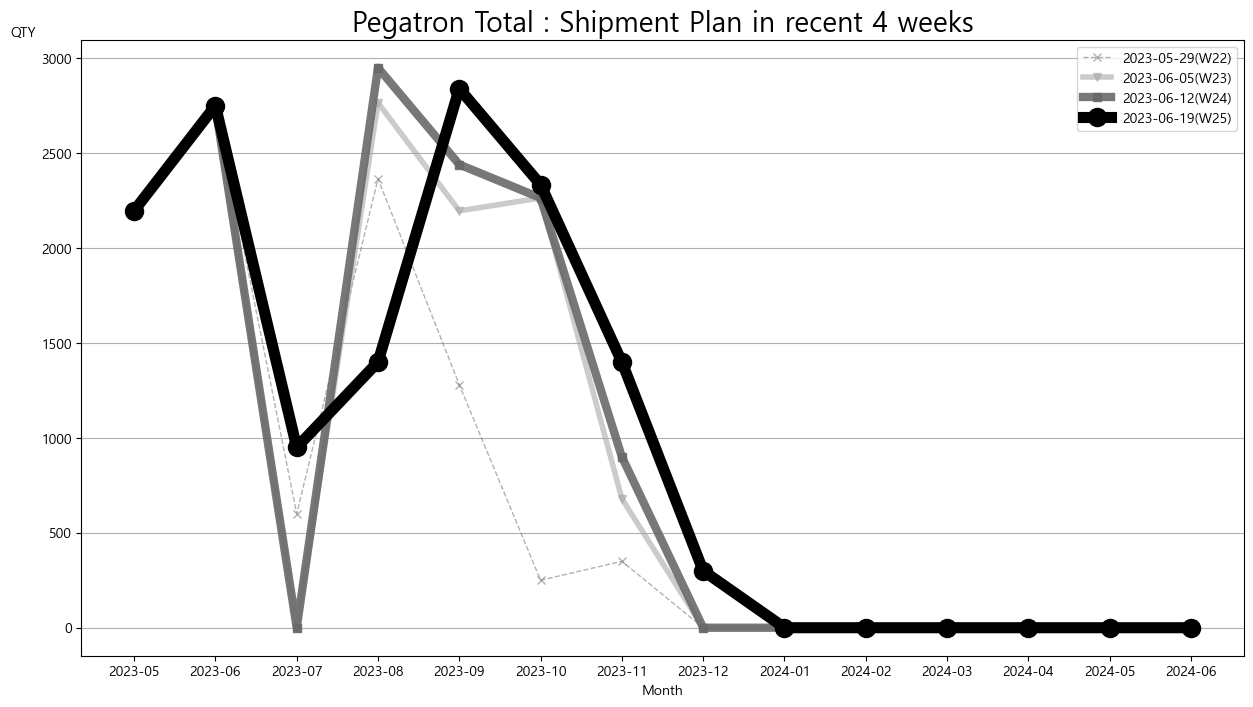

In [31]:
plot_forecast_change(df_fcst_ch, f'{vendor} Total : Shipment Plan in recent 4 weeks')

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_21664\108344638.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_t = df_summary.groupby('Series').sum()
C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_21664\108344638.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_t1 = category_sum(pg_lastweek.groupby('Series').sum())


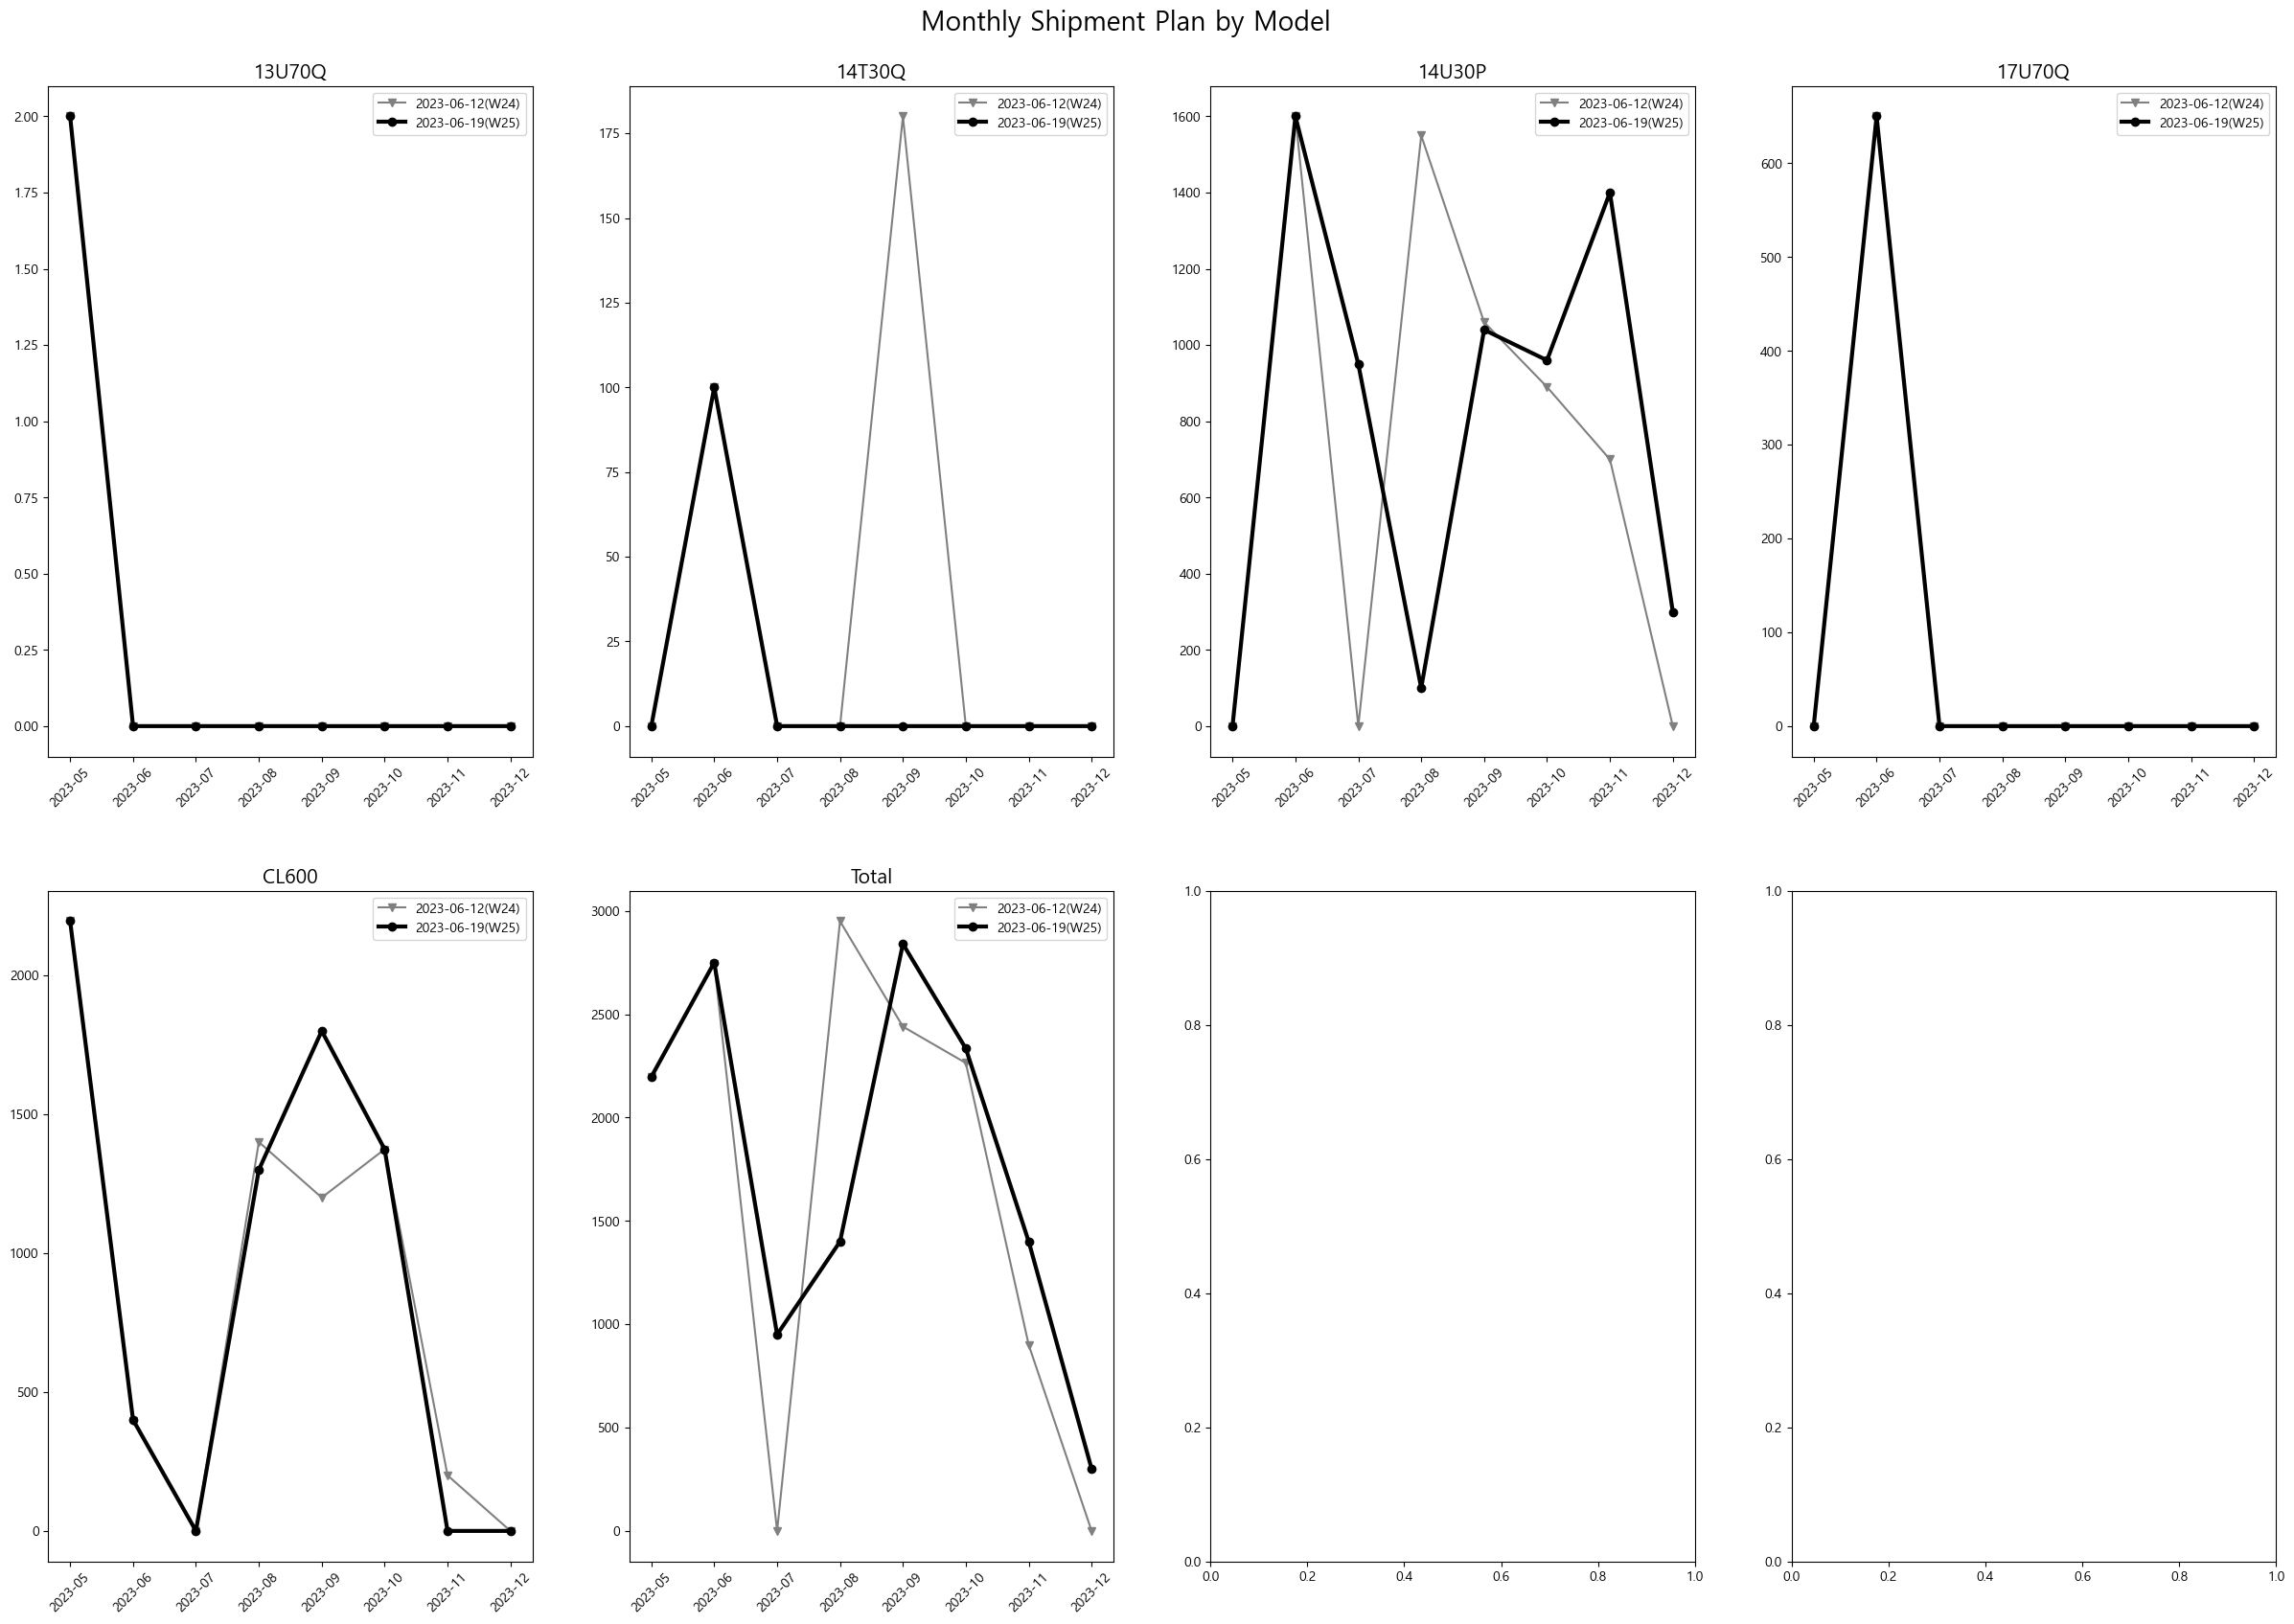

In [32]:
df_diff = get_difference_table(pg_thisweek.copy(), pg_lastweek.copy(), '-\d\d-')[get_pattern_from_list(pg_thisweek.columns, re.compile('\d-\d'))]
df_diff['Sum'] = df_diff.sum(axis=1)

# 전주 대비 월별 증감 내역 산출
diff_table_by_month = get_difference_table(monthly_sum(pg_thisweek.copy(), ['Series', 'Region']).reset_index(),
                                           monthly_sum(pg_lastweek.copy(), ['Series', 'Region']).reset_index(),
                                           '\d-\d')[monthly_sum(pg_thisweek.copy(), ['Series', 'Region']).columns]

for name in diff_table_by_month.columns:
    diff_table_by_month.rename(columns={name:'Gap_'+name}, inplace=True)

diff_table_by_month['Sum_Gap'] = diff_table_by_month.sum(axis=1)
df_month1 = monthly_sum(pg_thisweek.copy(), ['Series', 'Region'])
df_month1['Sum'] = df_month1.sum(axis=1)

df_summary = pd.concat([df_month1, diff_table_by_month], axis=1)
df_summary.reset_index(inplace=True)
df_summary.insert(1, 'Vendor_Model',df_summary['Series'].replace(supplier_model_map))

# 2-1) 전주대비 모델별월별 합계 수량 차트 그리기
df_t = df_summary.groupby('Series').sum()
df_t.loc['Total'] = df_t.sum()
df_t = df_t[get_pattern_from_list(df_t, re.compile('^\d'))]

df_t1 = category_sum(pg_lastweek.groupby('Series').sum())
df_t1.loc['Total'] = df_t1.sum()


df_t2 = pd.DataFrame(data=0, index=df_t.index, columns=df_t.columns)

for i in df_t2.index:
    for j in df_t2.columns:
        try:
            sp_value = df_t1.loc[i, j]
        except:
            sp_value = 0
        df_t2.loc[i, j] = sp_value

lst = df_t.index.tolist()
a1 = len(lst) // 4
b1 = len(lst) % 4
if b1 != 0:
    a1 += 1

fig, axs = plt.subplots(a1, 4, figsize=(30, 20))
fig.suptitle('Monthly Shipment Plan by Model', fontsize=20, y=0.92)

for i, model in enumerate(lst):
    i1 = i // 4
    i2 = i % 4
    axs[i1, i2].plot(df_t2.columns, df_t2.loc[model].tolist(), color='grey', marker='v', label=lastweek)
    axs[i1, i2].plot(df_t.columns, df_t.loc[model].tolist(), lw=3, marker='o', color='k', label=thisweek)
    axs[i1, i2].set_title(model, fontsize=15)
    axs[i1, i2].xaxis.set_tick_params(rotation=45)
    axs[i1, i2].legend()
plt.savefig('D:/figure/monthly_shipment_plan_by_model.png', bbox_inches='tight', pad_inches = 0)

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_21664\1329133039.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_t = df_summary.groupby('Region').sum()
C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_21664\1329133039.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_t1 = category_sum(pg_lastweek.groupby('Region').sum())


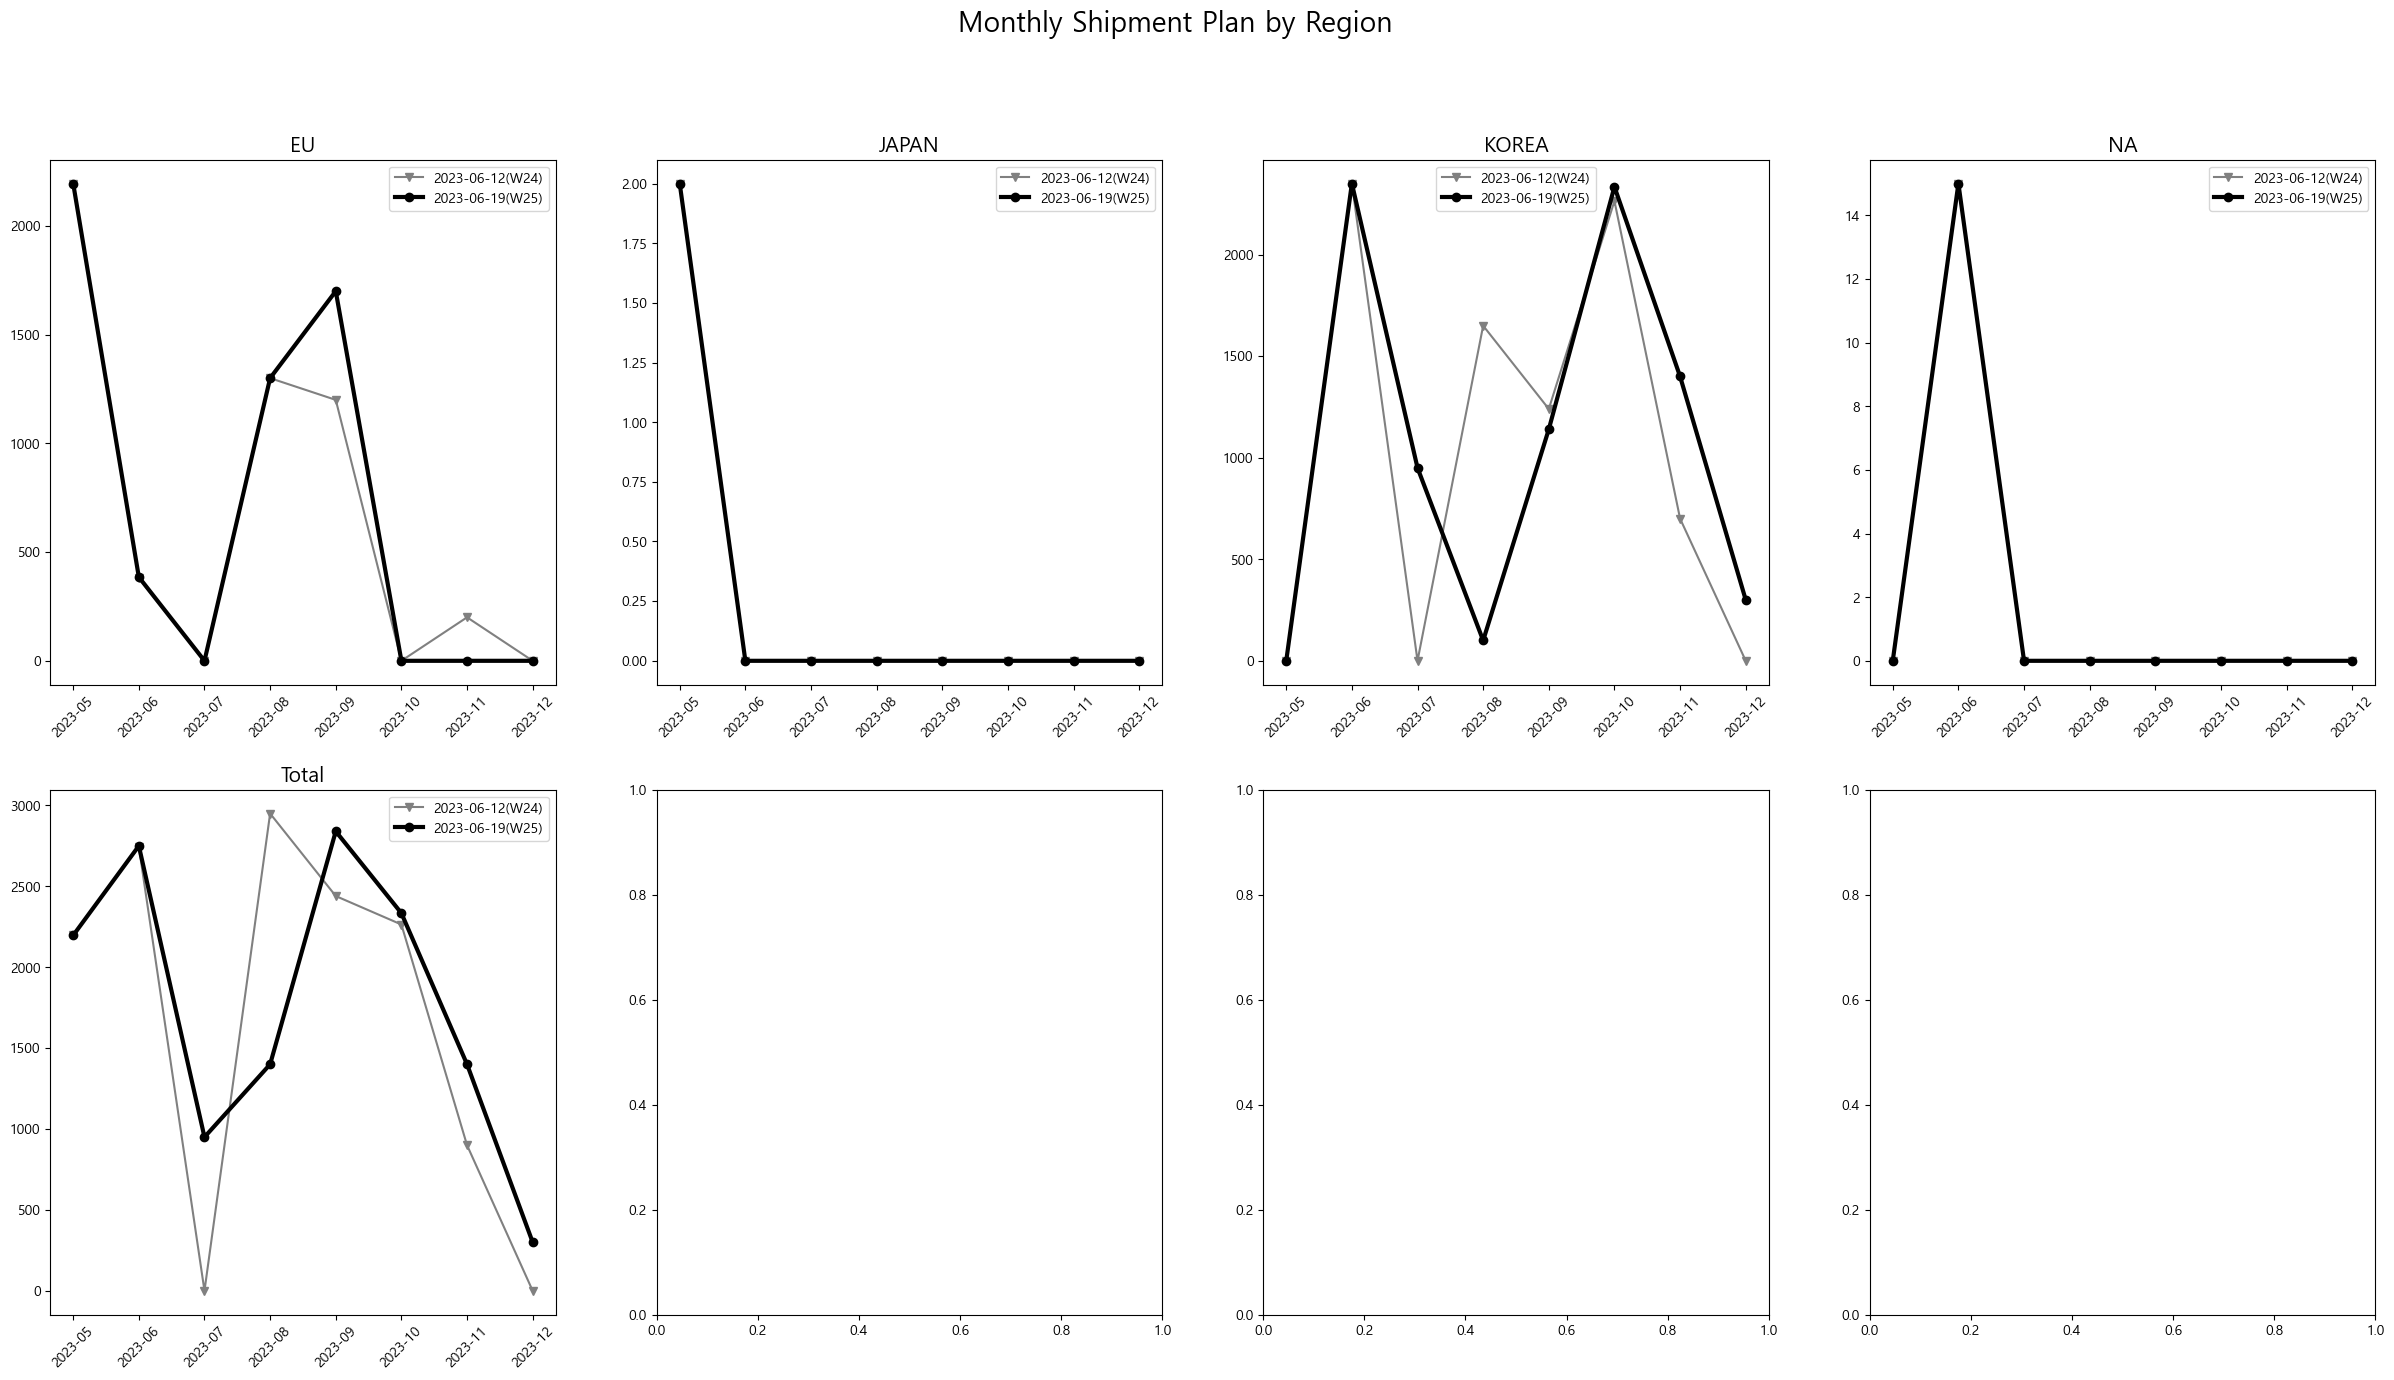

In [33]:
# 2-3) 전주대비 지역별 월별 수량 차트 그리기
df_t = df_summary.groupby('Region').sum()
df_t.loc['Total'] = df_t.sum()
df_t = df_t[get_pattern_from_list(df_t, re.compile('^\d'))]

df_t1 = category_sum(pg_lastweek.groupby('Region').sum())
df_t1.loc['Total'] = df_t1.sum()

df_t2 = pd.DataFrame(data=0, index=df_t.index, columns=df_t.columns)

for i in df_t2.index:
    for j in df_t2.columns:
        try:
            sp_value = df_t1.loc[i, j]
        except:
            sp_value = 0
        df_t2.loc[i, j] = sp_value

lst = df_t.index.tolist()
a1 = len(lst) // 4
b1 = len(lst) % 4
if b1 != 0:
    a1 += 1

fig, axs = plt.subplots(a1, 4, figsize=(30, 15))
fig.suptitle('Monthly Shipment Plan by Region', fontsize=20)

for i, region in enumerate(lst):
    if a1 == 1:
        i2 = i % 4
        axs[i2].plot(df_t2.columns, df_t2.loc[region].tolist(), marker='v', color='grey', label=lastweek)
        axs[i2].plot(df_t.columns, df_t.loc[region].tolist(), lw=3, marker='o', color='k', label=thisweek)
        axs[i2].set_title(region, fontsize=15)
        axs[i2].xaxis.set_tick_params(rotation=45)
        axs[i2].legend()
    else:
        i1 = i // 4
        i2 = i % 4
        axs[i1, i2].plot(df_t2.columns, df_t2.loc[region].tolist(), marker='v', color='grey', label=lastweek)
        axs[i1, i2].plot(df_t.columns, df_t.loc[region].tolist(), lw=3, marker='o', color='k', label=thisweek)
        axs[i1, i2].set_title(region, fontsize=15)
        axs[i1, i2].xaxis.set_tick_params(rotation=45)
        axs[i1, i2].legend()
plt.savefig('D:/figure/monthly_shipment_plan_by_region.png', bbox_inches='tight', pad_inches=0)

## 3. Forecast 구간에서 운영되는 SKU 수 확인

In [34]:
df_sku = pg_thisweek.groupby(['Series', 'Country'])['Mapping Model.Suffix'].count()
df_sku.name = thisweek
df_sku_lastweek = pg_lastweek.groupby(['Series', 'Country'])['Mapping Model.Suffix'].count()
df_sku_lastweek.name = lastweek
df_sku_count = pd.concat([df_sku, df_sku_lastweek], axis=1)
df_sku_count = df_sku_count.reset_index()
df_sku_count.insert(1, 'Vendor_Model', df_sku_count['Series'].replace(supplier_model_map))
df_sku_count.fillna(0, inplace=True)
df_sku_count = df_sku_count.convert_dtypes()

## 4. 현재 시점의 OPEN PO 현황 구하기

In [35]:
# OPEN PO 현황 구하기
open_po_df = get_open_po('Pegatron').reset_index()
open_po =  pd.pivot_table(open_po_df, index=['Series', 'Mapping Model.Suffix', 'Country', 'PO No.', 'Unit Price'], columns='RSD Week Name', values='Open_Qty', aggfunc=sum).reset_index()
open_po.insert(0, 'Vendor_Model', open_po['Series'].replace(supplier_model_map))

## 5. 선적 결과 구하기

In [36]:
with open('D:/Data/Pegatron shipment result DB.bin', 'rb') as f:
    SR_df = pickle.load(f)

SR_df = SR_df.reset_index()
frozen = 3
year_lastmonth, last_month = get_lastmonth(thisweek)
thismonth_wklist = get_weeklist_for_certain_month(today.isocalendar()[0], get_month_from_date(today))
pastweek = get_weeklist_for_certain_month(year_lastmonth, last_month) + thismonth_wklist[:thismonth_wklist.index(thisweek)] # 금주 기준 이전주차의 리스트
weeklist = pastweek + [get_weekname_from(thisweek, i) for i in range(frozen+1)]

cond1 = SR_df['Week Name'].isin(weeklist)
shipment_list = SR_df[cond1].pivot_table('Ship', index=['Region', 'Country', 'PO No.', 'BL No', 'Ship Date', 'Mapping Model.Suffix', 'Unit Price', 'RSD Week Name'],
                  columns='Week Name', aggfunc=sum).fillna(0).reset_index()
shipment_list['Ship Date'] = shipment_list['Ship Date'].dt.date

## 7. 최종 결과물을 엑셀파일로 생성

In [37]:
# 정확한 파일명 생성을 위해 하기 변수값 확인
today_str = (today - datetime.timedelta(days=today.isocalendar()[2]-1)).strftime('%Y%m%d')
week_num = today.isocalendar()[1] # 이번주의 주차숫자(Week Number)를 구함
update_time = datetime.datetime.now().strftime('%y%m%d%H')

file_name = f"{update_time}_W{week_num}_Pegatron_weekly_forecast_{ver1}.xlsx" #이번주 forecast 파일을 저장할 이름 설정

with pd.ExcelWriter("D:/Shipment Plan/Pegatron Shipment Plan/"+file_name) as writer:
    df_summary.to_excel(writer, sheet_name='Monthly', index=False, startrow=1)
    pg_thisweek.to_excel(writer, sheet_name=thisweek, index=False, startrow=1)
    open_po.to_excel(writer, merge_cells=False, sheet_name='OpenPO', index=False, startrow=1)
    df_diff.to_excel(writer, merge_cells=False, sheet_name='GapFromLastweek', index=True, startrow=1)
    df_sku_count.to_excel(writer, sheet_name='SKU Count', merge_cells=False, index=False, startrow=1)
    shipment_list.to_excel(writer, sheet_name='Shipment Result', merge_cells=False, index=False, startrow=1)

## 8. 엑셀 편집 및 이미지 삽입

In [38]:
fn = get_filename()
wb = load_workbook(fn)

color = PatternFill(fgColor='BFBFBF', fill_type='solid')

# 첫번째 Sheet(Monthyl)
sh = wb[wb.sheetnames[0]]
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
for i in range(4, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'
sh.freeze_panes = 'D3'
# 두번째 Sheet(주간SP)
sh = wb[wb.sheetnames[1]]
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
sh.column_dimensions['B'].width = 17
for i in range(6, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'
sh.freeze_panes = 'F3'

# 3번째 Sheet(Open PO)
sh = wb[wb.sheetnames[2]]
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
sh.column_dimensions['C'].width = 17
sh.column_dimensions['E'].width = 15
for i in range(7, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'
sh.freeze_panes = 'G3'
# 4번째 Sheet(Gap)
sh = wb[wb.sheetnames[3]]
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
sh.column_dimensions['B'].width = 17
sh.freeze_panes = 'F3'
for i in range(6, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'
# 5번째 Sheet(SKU count)
sh = wb[wb.sheetnames[4]]
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
sh.freeze_panes = 'D3'
for i in range(4, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'

# 6번째 Sheet(shipment result)
sh = wb[wb.sheetnames[5]]
sh.freeze_panes = 'I3'
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
sh.column_dimensions['C'].width = 15
sh.column_dimensions['D'].width = 14
sh.column_dimensions['E'].width = 12
sh.column_dimensions['F'].width = 17
sh.column_dimensions['H'].width = 16
for i in range(9, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'

wb.create_sheet('Chart')
img1 = Image('D:/figure/forecast_change_during_4weeks.png')
img2 = Image('D:/figure/monthly_shipment_plan_by_model.png')
img3 = Image('D:/figure/monthly_shipment_plan_by_region.png')
ws = wb['Chart']

ws.add_image(img1, 'A1')
ws.add_image(img2, 'A27')
ws.add_image(img3, 'A81')

sh_names = wb.sheetnames
for sh in sh_names:
    wb[sh].sheet_view.showGridLines = False

wb.save(fn)